In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import pickleslicer
from stoqcompiler.unitary import *
from stoqcompiler.verification import *

import jaqalpaq
from jaqalpaq.parser import parse_jaqal_string
from jaqalpaq.emulator import run_jaqal_circuit
from jaqalpaq.generator import generate_jaqal_program
from qscout.v1.native_gates import U_R, U_MS, U_Rz

## Define the 2-qubit system parameters

In [2]:
num_system_qubits = 2

qubit_dimension = 2
system_dimension = qubit_dimension ** num_system_qubits
qubits_to_use = [q for q in range(num_system_qubits)]

def qscout_r(max_angle):
    min_value = -max_angle
    max_value = max_angle
    parameters = [ParameterizedUnitaryParameter("Φ", -np.pi, np.pi, is_angle=True),
                  ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "R"
    connectivity = [[q] for q in range(num_system_qubits)]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension, U_R, parameters, operation_name), allowed_apply_to)

def qscout_rz(max_angle):
    min_value = -max_angle
    max_value = max_angle
    parameters = [ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "Rz"
    connectivity = [[q] for q in range(num_system_qubits)]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension, U_Rz, parameters, operation_name), allowed_apply_to)

def qscout_ms(max_angle):
    min_value = -max_angle
    max_value = max_angle
    dimension = 2
    parameters = [ParameterizedUnitaryParameter("Φ", -np.pi, np.pi, is_angle=True),
                  ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "MS"
    connectivity = [[i,j] for i in range(num_system_qubits) for j in range(num_system_qubits) if i != j]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension ** 2, U_MS, parameters, operation_name), allowed_apply_to)

## How RAV uncertainty scales with # of shots

- Choose a representative long-enough random RAV circuit with ideal output state $\lvert\psi\rangle \approx \sqrt{1-\epsilon} \lvert0\rangle + \sqrt{\epsilon} \lvert\textrm{other states}\rangle$
- Plot a whole bunch of points, x-axis = # shots, y-axis = initial state probability, for:
   - 100% ideal output state $2^n \cdot \rho = \lvert\psi\rangle\langle\psi\rvert$
   - 75% ideal output state $2^n \cdot \rho = \frac{3}{4} \lvert\psi\rangle\langle\psi\rvert + \frac{1}{4} I$
   - 50% ideal output state $2^n \cdot \rho = \frac{1}{2} \lvert\psi\rangle\langle\psi\rvert + \frac{1}{2} I$
   - 25% ideal output state $2^n \cdot \rho = \frac{1}{4} \lvert\psi\rangle\langle\psi\rvert + \frac{3}{4} I$
   - completely mixed output state $2^n \cdot \rho = I$

In [3]:
unitary_primitive_counts = {
    qscout_r(max_angle=np.pi/10): 3,
    qscout_rz(max_angle=np.pi/10): 3,
    qscout_ms(max_angle=np.pi/10): 1
}

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
directory = f"output_ideal_rav_vs_xeb_simulations/{timestamp}"
if not os.path.exists(directory):
    os.makedirs(directory)

In [4]:
sequence_count = 20
layer_count = 10

rav_results = []
for seq_idx in range(sequence_count):
    final_cost = 1.0
    while final_cost > 0.02:
        rav_result = Verification.generate_layered_rav_sequence(
            system_dimension,
            unitary_primitive_counts,
            layer_count,
            max_step_count = 4000,
            threshold = 1.0,
        )

        product = rav_result.compiled_sequence.product()
        identity = Unitary.identity(system_dimension)
        final_cost = product.distance_from(identity)

        print(f"generated circuit: length {rav_result.compiled_sequence.get_length()} with final cost {final_cost}")

    rav_results.append(rav_result)
    filename = f'{directory}/rav_{num_system_qubits}q_{layer_count}_{seq_idx}.txt'
    with open(filename, 'w') as f:
        f.write(f'''
    from qscout.v1.std usepulses *
    register q[{len(qubits_to_use)}]
    prepare_all
    ''')
        f.write(rav_result.compiled_sequence.get_jaqal())
        f.write(f'''
    measure_all
    ''')

    print(f"SUCCESS: wrote JAQAL circuit to {filename}")

generated circuit: length 98 with final cost 0.015468345682859375
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_131316/rav_2q_10_0.txt
generated circuit: length 147 with final cost 0.02340908433017408
generated circuit: length 126 with final cost 0.046098932171655504
generated circuit: length 133 with final cost 0.021460876643882743
generated circuit: length 119 with final cost 0.032849005221280425
generated circuit: length 105 with final cost 0.009953105663584871
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_131316/rav_2q_10_1.txt
generated circuit: length 126 with final cost 0.01931528403832461
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_131316/rav_2q_10_2.txt
generated circuit: length 126 with final cost 0.03849304873921888
generated circuit: length 259 with final cost 0.02229114410099342
generated circuit: length 245 with final cost 0.014118604203333995
SUCCESS: wrote JAQAL circuit to out

In [5]:
rav_x_data = {}
rav_y_data = {}    
for seq_idx, rav_result in enumerate(rav_results):
    rav_sequence_matrix = rav_result.compiled_sequence.product().get_matrix()

    mixed_state_fraction_list = [0.0, 0.25, 0.5, 0.75, 1.0]

    rav_x_data[seq_idx] = {}
    rav_y_data[seq_idx] = {}

    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        initial_state_index = 1

        # calculate the ideal output state
        initial_state = np.zeros(system_dimension)
        initial_state[initial_state_index] = 1
        initial_state = np.atleast_2d(initial_state).T
        ideal_output_state = rav_sequence_matrix @ initial_state
        #print("ideal_output_state coefficients:", np.round(ideal_output_state.T, 4))

        # validate the state
        ideal_output_probs = np.array([np.linalg.norm(c)**2 for c in ideal_output_state])
        #print("ideal_output_probs =", np.round(ideal_output_probs, 4))
        sum_of_probs = np.sum([np.linalg.norm(c)**2 for c in ideal_output_state])
        assert np.isclose(sum_of_probs, 1.0)

        # mix in the mixed state fraction
        mixed_state_output_probs = np.array([1/system_dimension for _ in range(system_dimension)])
        output_probs = np.add(
            (1-mixed_state_fraction) * ideal_output_probs,
            mixed_state_fraction * mixed_state_output_probs
        )
        print(f"mixed_state_fraction = {mixed_state_fraction}, output_probs = {np.round(output_probs, 4)}")

        # sample many times and plot
        n_shots_list = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
        repetitions = 100
        rav_x_data[seq_idx][mixed_state_fraction] = []
        rav_y_data[seq_idx][mixed_state_fraction] = []
        for n_shots in n_shots_list:
            for _ in range(repetitions):
                measurements = [int(np.random.random() < output_probs[initial_state_index]) for _ in range(n_shots)]
                scaled_fidelity = (np.mean(measurements) - 1/system_dimension) * (system_dimension/(system_dimension-1))

                rav_x_data[seq_idx][mixed_state_fraction].append(n_shots)
                rav_y_data[seq_idx][mixed_state_fraction].append(scaled_fidelity)

mixed_state_fraction = 0.0, output_probs = [0.0031 0.9535 0.0161 0.0274]
mixed_state_fraction = 0.25, output_probs = [0.0648 0.7776 0.0746 0.083 ]
mixed_state_fraction = 0.5, output_probs = [0.1265 0.6017 0.133  0.1387]
mixed_state_fraction = 0.75, output_probs = [0.1883 0.4259 0.1915 0.1943]
mixed_state_fraction = 1.0, output_probs = [0.25 0.25 0.25 0.25]
mixed_state_fraction = 0.0, output_probs = [0.0038 0.9717 0.001  0.0235]
mixed_state_fraction = 0.25, output_probs = [0.0654 0.7913 0.0633 0.0801]
mixed_state_fraction = 0.5, output_probs = [0.1269 0.6108 0.1255 0.1367]
mixed_state_fraction = 0.75, output_probs = [0.1885 0.4304 0.1878 0.1934]
mixed_state_fraction = 1.0, output_probs = [0.25 0.25 0.25 0.25]
mixed_state_fraction = 0.0, output_probs = [1.140e-02 9.764e-01 2.000e-04 1.200e-02]
mixed_state_fraction = 0.25, output_probs = [0.0711 0.7948 0.0626 0.0715]
mixed_state_fraction = 0.5, output_probs = [0.1307 0.6132 0.1251 0.131 ]
mixed_state_fraction = 0.75, output_probs = [0.190

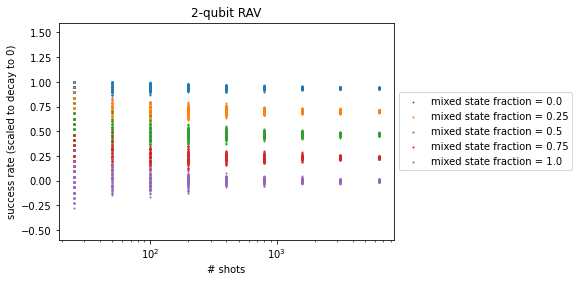

In [6]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    plt.scatter(
        rav_x_data[0][mixed_state_fraction],
        rav_y_data[0][mixed_state_fraction],
        s=1, label=f'mixed state fraction = {mixed_state_fraction}')
    
plt.ylim(-0.6, 1.6)
plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('success rate (scaled to decay to 0)')
plt.title(f'{num_system_qubits}-qubit RAV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [7]:
rav_std_data = {}
for seq_idx, rav_result in enumerate(rav_results):
    rav_std_data[seq_idx] = {}
    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        rav_std_data[seq_idx][mixed_state_fraction] = []    
        for n_shots in n_shots_list:
            current_slice = np.array(rav_x_data[seq_idx][mixed_state_fraction]) == n_shots
            y_vals = np.extract(current_slice, rav_y_data[seq_idx][mixed_state_fraction])
            rav_std_data[seq_idx][mixed_state_fraction].append(np.std(y_vals))

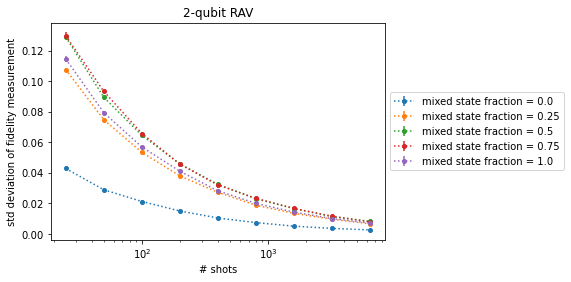

In [8]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    y_raw = [rav_std_data[seq_idx][mixed_state_fraction] for seq_idx in rav_std_data]
    plt.errorbar(
        n_shots_list,
        y=np.mean(y_raw, axis=0),
        yerr=np.std(y_raw, axis=0) / np.sqrt(sequence_count),
        marker='.',
        markersize=8, label=f'mixed state fraction = {mixed_state_fraction}',
        linestyle='dotted')

plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('std deviation of fidelity measurement')
plt.title(f'{num_system_qubits}-qubit RAV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## How XEB uncertainty scales with # of shots

- Choose a representative random circuit of same length used above for RAV with ideal output state $\lvert\phi\rangle$
- Plot a whole bunch of points, x-axis = # shots, y-axis = initial state probability, for:
   - 100% ideal output state $2^n \cdot \rho = \lvert\phi\rangle\langle\phi\rvert$
   - 75% ideal output state $2^n \cdot \rho = \frac{3}{4} \lvert\phi\rangle\langle\phi\rvert + \frac{1}{4} I$
   - 50% ideal output state $2^n \cdot \rho = \frac{1}{2} \lvert\phi\rangle\langle\phi\rvert + \frac{1}{2} I$
   - 25% ideal output state $2^n \cdot \rho = \frac{1}{4} \lvert\phi\rangle\langle\phi\rvert + \frac{3}{4} I$
   - completely mixed output state $2^n \cdot \rho = I$

In [9]:
xeb_results = []
for seq_idx in range(sequence_count):
    xeb_layer_count = rav_results[seq_idx].compiled_sequence.get_length() // int(sum(list(unitary_primitive_counts.values())))

    xeb_result = Verification.generate_layered_rav_sequence(
        system_dimension,
        unitary_primitive_counts,
        xeb_layer_count,
        max_step_count = 0,
        threshold = 0.0,
    )

    product = xeb_result.compiled_sequence.product()
    identity = Unitary.identity(system_dimension)
    final_cost = product.distance_from(identity)

    print(f"generated XEB circuit: length {xeb_result.compiled_sequence.get_length()} with final cost {final_cost}")

    xeb_results.append(xeb_result)

    filename = f'{directory}/xeb_{num_system_qubits}q_{xeb_layer_count}_{seq_idx}.txt'
    with open(filename, 'w') as f:
        f.write(f'''
    from qscout.v1.std usepulses *
    register q[{len(qubits_to_use)}]
    prepare_all
    ''')
        f.write(xeb_result.compiled_sequence.get_jaqal())
        f.write(f'''
    measure_all
    ''')

    print(f"SUCCESS: wrote JAQAL circuit to {filename}")

generated XEB circuit: length 98 with final cost 0.1585519550208485
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_131316/xeb_2q_14_0.txt
generated XEB circuit: length 105 with final cost 0.3868364637085183
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_131316/xeb_2q_15_1.txt
generated XEB circuit: length 126 with final cost 0.4689377913574365
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_131316/xeb_2q_18_2.txt
generated XEB circuit: length 245 with final cost 0.5930015790743721
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_131316/xeb_2q_35_3.txt
generated XEB circuit: length 210 with final cost 0.46203368583587545
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_131316/xeb_2q_30_4.txt
generated XEB circuit: length 217 with final cost 0.6454928266041674
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220417_131316/xe

In [10]:
xeb_x_data = {}
xeb_y_data = {}    
for seq_idx, xeb_result in enumerate(xeb_results):
    xeb_sequence_matrix = xeb_result.compiled_sequence.product().get_matrix()

    mixed_state_fraction_list = [0.0, 0.25, 0.5, 0.75, 1.0]

    xeb_x_data[seq_idx] = {}
    xeb_y_data[seq_idx] = {}

    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        initial_state_index = 1

        # calculate the ideal output state
        initial_state = np.zeros(system_dimension)
        initial_state[initial_state_index] = 1
        initial_state = np.atleast_2d(initial_state).T
        ideal_output_state = xeb_sequence_matrix @ initial_state
        #print("ideal_output_state coefficients:", np.round(ideal_output_state.T, 4))

        # validate the state
        ideal_output_probs = np.array([np.linalg.norm(c)**2 for c in ideal_output_state])
        #print("ideal_output_probs =", np.round(ideal_output_probs, 4))
        sum_of_probs = np.sum([np.linalg.norm(c)**2 for c in ideal_output_state])
        assert np.isclose(sum_of_probs, 1.0)

        # mix in the mixed state fraction
        mixed_state_output_probs = np.array([1/system_dimension for _ in range(system_dimension)])
        output_probs = np.add(
            (1-mixed_state_fraction) * ideal_output_probs,
            mixed_state_fraction * mixed_state_output_probs
        )
        print(f"mixed_state_fraction = {mixed_state_fraction}, output_probs = {np.round(output_probs, 4)}")

        # sample many times and plot
        n_shots_list = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
        repetitions = 100
        xeb_x_data[seq_idx][mixed_state_fraction] = []
        xeb_y_data[seq_idx][mixed_state_fraction] = []
        for n_shots in n_shots_list:
            for _ in range(repetitions):
                measurements = [int(np.random.random() < output_probs[initial_state_index]) for _ in range(n_shots)]
                measurements = np.random.choice(system_dimension, size=n_shots, p=output_probs)
                measurement_probs = [np.count_nonzero(measurements == k) / n_shots for k in range(system_dimension)]
                assert np.isclose(np.sum(measurement_probs), 1.0)

                # calculate cross-entropy fidelity between ideal_output_probs, measurement_probs
                e_u = np.sum(ideal_output_probs**2)
                u_u = np.sum(ideal_output_probs) / system_dimension
                m_u = np.sum(ideal_output_probs * measurement_probs)
                y = m_u - u_u
                x = e_u - u_u
                fidelity = (x * y) / (x ** 2)

                xeb_x_data[seq_idx][mixed_state_fraction].append(n_shots)
                xeb_y_data[seq_idx][mixed_state_fraction].append(fidelity)

mixed_state_fraction = 0.0, output_probs = [0.0092 0.7734 0.0321 0.1853]
mixed_state_fraction = 0.25, output_probs = [0.0694 0.6426 0.0866 0.2014]
mixed_state_fraction = 0.5, output_probs = [0.1296 0.5117 0.1411 0.2176]
mixed_state_fraction = 0.75, output_probs = [0.1898 0.3809 0.1955 0.2338]
mixed_state_fraction = 1.0, output_probs = [0.25 0.25 0.25 0.25]
mixed_state_fraction = 0.0, output_probs = [0.1683 0.6912 0.132  0.0086]
mixed_state_fraction = 0.25, output_probs = [0.1887 0.5809 0.1615 0.069 ]
mixed_state_fraction = 0.5, output_probs = [0.2091 0.4706 0.191  0.1293]
mixed_state_fraction = 0.75, output_probs = [0.2296 0.3603 0.2205 0.1897]
mixed_state_fraction = 1.0, output_probs = [0.25 0.25 0.25 0.25]
mixed_state_fraction = 0.0, output_probs = [0.0137 0.8011 0.0983 0.0868]
mixed_state_fraction = 0.25, output_probs = [0.0728 0.6634 0.1362 0.1276]
mixed_state_fraction = 0.5, output_probs = [0.1319 0.5256 0.1742 0.1684]
mixed_state_fraction = 0.75, output_probs = [0.1909 0.3878 0.2

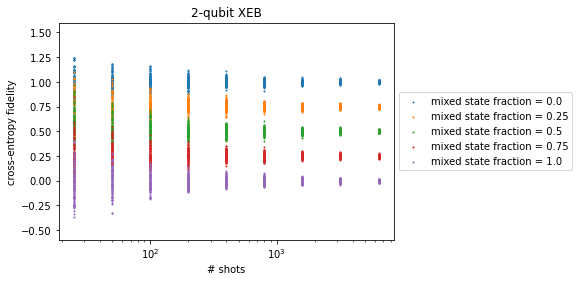

In [11]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    plt.scatter(
        xeb_x_data[0][mixed_state_fraction],
        xeb_y_data[0][mixed_state_fraction],
        s=1, label=f'mixed state fraction = {mixed_state_fraction}')

plt.ylim(-0.6, 1.6)
plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('cross-entropy fidelity')
plt.title(f'{num_system_qubits}-qubit XEB')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
xeb_std_data = {}
for seq_idx, xeb_result in enumerate(xeb_results):
    xeb_std_data[seq_idx] = {}
    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        xeb_std_data[seq_idx][mixed_state_fraction] = []    
        for n_shots in n_shots_list:
            current_slice = np.array(xeb_x_data[seq_idx][mixed_state_fraction]) == n_shots
            y_vals = np.extract(current_slice, xeb_y_data[seq_idx][mixed_state_fraction])
            xeb_std_data[seq_idx][mixed_state_fraction].append(np.std(y_vals))

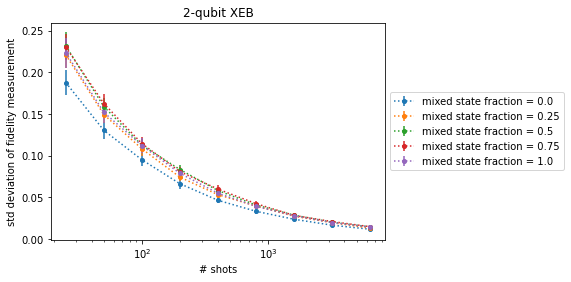

In [13]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    y_raw = [xeb_std_data[seq_idx][mixed_state_fraction] for seq_idx in xeb_std_data]
    plt.errorbar(
        n_shots_list,
        y=np.mean(y_raw, axis=0),
        yerr=np.std(y_raw, axis=0) / np.sqrt(sequence_count),
        marker='.',
        markersize=8, label=f'mixed state fraction = {mixed_state_fraction}',
        linestyle='dotted')

plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('std deviation of fidelity measurement')
plt.title(f'{num_system_qubits}-qubit XEB')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [14]:
save_data = {
    "mixed_state_fraction_list": mixed_state_fraction_list,
    "n_shots_list": n_shots_list,
    "rav_x_data": rav_x_data,
    "rav_y_data": rav_y_data,
    "rav_std_data": rav_std_data,
    "xeb_x_data": xeb_x_data,
    "xeb_y_data": xeb_y_data,
    "xeb_std_data": xeb_std_data,
}
pickleslicer.dump(save_data, f'{directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')
print(f'Saved to {directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')

Saved to output_ideal_rav_vs_xeb_simulations/20220417_131316/ideal_rav_vs_xeb_simulations_2q.pickle


In [16]:
directory = 'output_ideal_rav_vs_xeb_simulations/20220417_131316'
load_data = pickleslicer.load(f'{directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')
mixed_state_fraction_list = load_data["mixed_state_fraction_list"]
n_shots_list = load_data["n_shots_list"]
rav_x_data = load_data["rav_x_data"]
rav_y_data = load_data["rav_y_data"]
rav_std_data = load_data["rav_std_data"]
xeb_x_data = load_data["xeb_x_data"]
xeb_y_data = load_data["xeb_y_data"]
xeb_std_data = load_data["xeb_std_data"]